In [1]:
# In order to have a reference line, a base model will be trained with face cropped and aligned for bonafide vs printed vs screen classes (3 classes).
# - obj: train over FLICKR and eval with FLICKR

# take json files and gather data to training format -> bonafide vs imposter

In [2]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils.paths import list_images
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

In [3]:
datapath = '../data/02_intermediate/flickr'
images_list = [*list_images(datapath)]
_classes = ('attack', 'bonafide')
_bf_index = _classes.index('bonafide')

In [4]:
_size = (224, 224)
bf, att = [], []

for imdir in images_list:
    if _classes[_bf_index] in imdir.split(os.sep): # if 'bonafide' in imdir
        bf.append(imdir)
    else:
        att.append(imdir)

In [5]:
len(bf), len(att)

(3000, 10975)

In [6]:
bf[0]

'../data/02_intermediate/flickr/bonafide/originales_ronda3y4/F12272.png'

In [7]:
def _parse_function(impath):
    # image reading
    image_string = tf.io.read_file(impath)
    image_decoded = tf.io.decode_png(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    image = tf.image.resize(image, _size)
    image = image / 255.
    
    # label setting
    _split = tf.strings.split(impath, sep=os.sep)
    _cls = _split[4]
    # 4th element is class id
    if _cls == 'bonafide':
        lb = tf.cast([1, 0], tf.float32)
    else:
        lb = tf.cast([0, 1], tf.float32)
    
    return image, lb

# How to make dataset

In [8]:
batch_size = 32
dataset = tf.cast(images_list, dtype=tf.string)
dataset = tf.data.Dataset.from_tensor_slices(dataset)
dataset = dataset.shuffle(batch_size)
dataset = dataset.map(_parse_function)
dataset = dataset.cache()
dataset = dataset.batch(batch_size)

2022-10-28 01:31:18.737736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 01:31:18.738231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 01:31:18.763846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 01:31:18.764249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 01:31:18.764912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

  0%|                                                                                                                                                                                      | 0/437 [00:00<?, ?it/s]


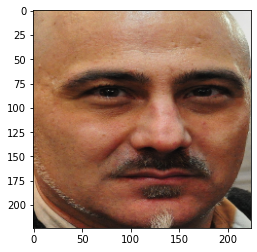

In [9]:
for bs in tqdm(dataset):
    im, lb = bs
    
    # print(lb)
    plt.imshow(im[0])
        
    break

In [10]:
# def train, test, val sets # done

In [11]:
bf_y = np.ones(len(bf))
att_y = np.zeros(len(att))

In [12]:
bf_y.shape, att_y.shape

((3000,), (10975,))

In [13]:
X = np.concatenate([bf, att])
y = np.concatenate([bf_y, att_y])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [15]:
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([6602, 1783]))

# Train data

In [16]:
train_dataset = tf.cast(X_train, dtype=tf.string)
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(batch_size)
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.batch(batch_size)

# Val data

In [17]:
val_dataset = tf.cast(X_val, dtype=tf.string)
val_dataset = tf.data.Dataset.from_tensor_slices(val_dataset)
val_dataset = val_dataset.shuffle(batch_size)
val_dataset = val_dataset.map(_parse_function)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.batch(1)

# Test data

In [18]:
# test_dataset = tf.cast(X_test, dtype=tf.string)
# test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset)
# test_dataset = val_dataset.shuffle(batch_size)
# test_dataset = val_dataset.map(_parse_function)
# test_dataset = val_dataset.cache()
# test_dataset = val_dataset.batch(1)

  0%|                                                                                                                                                                                      | 0/263 [00:01<?, ?it/s]

GT label: [1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1]


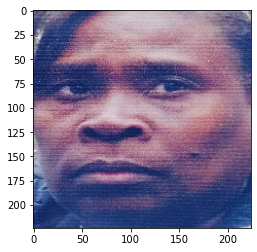

In [19]:
for bs in tqdm(train_dataset):
    im, lb = bs
    
    print('GT label:', np.argmax(lb, axis=-1))
    plt.imshow(im[0])
        
    break

In [20]:
# def model to be trained
# use aikit structure

In [21]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [22]:
input_shape = (*_size, 3) # 224x224x3

model = MobileNetV2(input_shape=input_shape, alpha=1.0, include_top=False, weights=None, pooling='max')

In [23]:
x = model.output
# Added by the 'pooling' argument
# x = GlobalAveragePooling2D()(x)
x = Dense(units=2, activation="softmax", use_bias=True, name="Logits")(x)

model = Model(inputs=model.input, outputs=x)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [25]:
from tensorflow.keras.metrics import CategoricalAccuracy

In [26]:
# compile model

learning_rate = 1e-4

# optimizer = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True, decay=1e-5)
optimizer = Adam(learning_rate=learning_rate, amsgrad=True, decay=1e-6)
loss = 'categorical_crossentropy'

model.compile(
    optimizer=optimizer, 
    loss=loss, 
    metrics=['acc', ], 
)

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=15, use_multiprocessing=True, workers=12)

Epoch 1/15


2022-10-28 01:31:26.413938: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-10-28 01:31:26.853619: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-28 01:31:26.862632: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


137/263 [==============>...............] - ETA: 2:29 - loss: 0.5925 - acc: 0.7395